## Library Imports

In [18]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt

## Data Cleaning
Cleaning the CSV data (data.csv).

-----------------------------------------------------------------------------------------------------------------------------------

- Group the data by it's item name and display their respective sales per month values
- Create another file for operation output:
  - item_count.csv for data manipulation purposes
  - item_count.xlsx to display data as excel file

In [19]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'data.csv'

# Read the CSV file into a DataFrame using ';' as the delimiter
df = pd.read_csv(file_path, delimiter=';')

# Assuming there's a 'Date' column representing dates in the dataset, replace 'Date' with your actual column name
df['ItemName'] = df['Description']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d/%m/%Y %H:%M")  # Convert to datetime format if the 'Date' column is not in datetime format

# Replace 'column_name' with the actual name of the column you want to analyze
column_to_analyze = 'ItemName'

df['Month'] = df['InvoiceDate'].dt.strftime('%m %Y')

# Group by 'column_to_analyze' and 'Month', calculate the sum of counts, and reset index
grouped_df = df.groupby([column_to_analyze, 'Month']).size().reset_index(name='Count')
sum_sales_per_item_per_month = grouped_df.groupby(['ItemName','Month'])['Count'].sum().reset_index()

# Pivot the table with items as rows and months as columns, summing up the counts
pivot_table = sum_sales_per_item_per_month.pivot_table(index='ItemName', columns='Month', values='Count', aggfunc='sum', fill_value=0)

# filtered_pivot_table = pivot_table[(pivot_table > 0).all(axis=1) & (pivot_table >= 0).all(axis=1)]

# Reorder the columns to have '12 2010' (December 2010) as the first column
columns_ordered = pivot_table.columns.tolist()
columns_ordered.sort(key=lambda x: (int(x.split()[1]), int(x.split()[0])))
filtered_pivot_table = pivot_table[columns_ordered]

# Export the pivot table to an Excel file
output_file = 'item_sales_count.csv'  # File name for the Excel output
filtered_pivot_table.to_csv(output_file, index=True)

output_file_alt = 'item_sales_count.xlsx'  # File name for the Excel output
filtered_pivot_table.to_excel(output_file_alt, index=True)

## Frequent Pattern Mining
Implement Frequent Pattern Mining method from item_count.csv.

-----------------------------------------------------------------------------------------------------------------------------------

- Create True/False value threshold (named df_threshold):
  - if sales data of that item in a month > 13 -> True
  - else -> False
- Assign apriori function:
  - max_len = 1 -> no association towards other item, only that specific item alone and their sales per month value
  - min_support=0.000001 -> must include all data within the threshold but since it's value cannot be 0 so we assigned 0.000001 instead
- Create category (classification) from the given apriori support value result (support means how often the item was in the threshold mark from the given period of time):
  - more than equals 0.6 -> "Profitable"
  - more than equals 0.3 & less than 0.6 -> "Re-evaluate"
  - less than 0.3 -> "Not Profitable"
- Make an output file for the apriori + classification result:
  - frequent_pattern_output.csv for data manipulation purposes
  - frequent_pattern_output.xlsx to display data as excel file

In [37]:
# Create a DataFrame with the provided data
file_path = 'item_count.csv'
data = pd.read_csv(file_path, delimiter=',')
df_item_count = pd.DataFrame(data)

# Transpose the DataFrame to make it suitable for frequent pattern mining
df_item_count.set_index('ItemName', inplace=True)
df_item_count = df_item_count.T

# Convert numerical values to boolean (True/False) based on a threshold (e.g., if sales > 30, set as True)
threshold = 13
df_threshold = df_item_count.applymap(lambda x: x > threshold)

# Find frequent itemsets using Apriori algorithm
frequent_itemsets = apriori(df_threshold, min_support=0.1667, max_len=1,use_colnames=True)
frequent_itemsets['Support'] = frequent_itemsets['support']

# single item only
frequent_itemsets['ItemName'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(x))

column_to_drop = ['itemsets', 'support']  # Column name to be removed
frequent_itemsets = frequent_itemsets.drop(columns=column_to_drop)

def classify_support(value):
    if value >= 0.667:
        return 'Profitable'
    elif value >= 0.334:
        return 'Re-evaluate'
    else:
        return 'Not Profitable'

frequent_itemsets['Category'] = frequent_itemsets['Support'].apply(classify_support)

output_file = 'frequent_pattern_output.csv'  # File name for the Excel output
frequent_itemsets.to_csv(output_file, index=False)

output_file_path_alt = 'frequent_pattern_output.xlsx'
frequent_itemsets.to_excel(output_file_path_alt, index=False)

## Plot
Plotting from frequent_pattern_output.csv based on the data category (classification).

-----------------------------------------------------------------------------------------------------------------------------------

Category
Re-evaluate       530
Profitable        524
Not Profitable    490
Name: count, dtype: int64


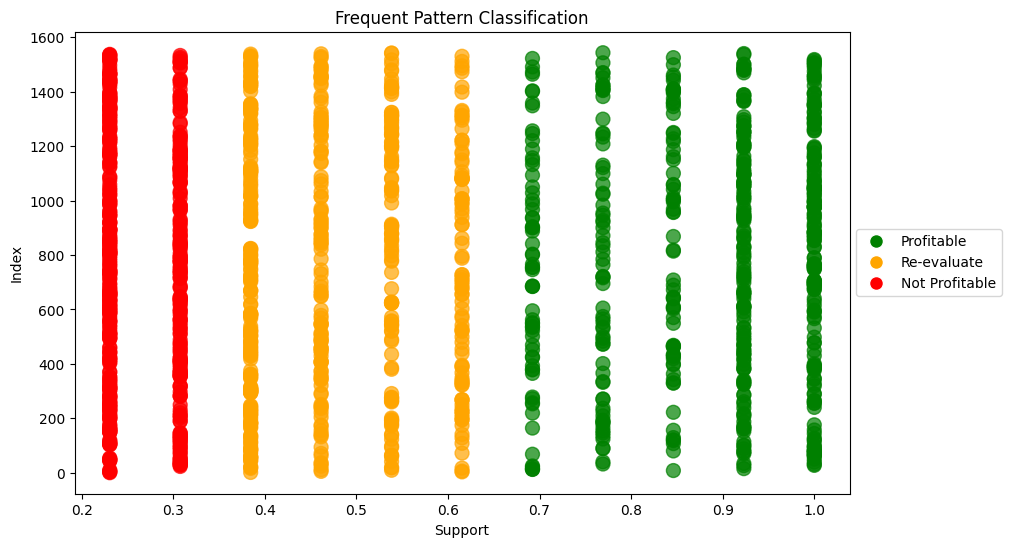

In [38]:
file_path = 'frequent_pattern_output.csv' 
data = pd.read_csv(file_path, delimiter=',')
df_frequent_pattern_output = pd.DataFrame(data)

category_counts = df_frequent_pattern_output['Category'].value_counts()

print(category_counts)

plt.figure(figsize=(10, 6))
colors = {'Profitable': 'green', 'Re-evaluate': 'orange', 'Not Profitable': 'red'}

plt.scatter(df_frequent_pattern_output['Support'], df_frequent_pattern_output.index, c=df_frequent_pattern_output['Category'].map(colors), s=100, alpha=0.7)
plt.ylabel('Index')
plt.xlabel('Support')
plt.title('Frequent Pattern Classification')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=label) for label in colors],
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
